In [70]:
from bs4 import BeautifulSoup
import csv
from itertools import chain
from imblearn.over_sampling import SMOTE
from keras.layers import Bidirectional, GlobalMaxPool1D,Conv1D
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.models import Model
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import os
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import nltk
from nltk.stem import WordNetLemmatizer
import numpy as np
import regex as re
import seaborn as sns
import string
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay, RocCurveDisplay, roc_auc_score, roc_curve, auc, f1_score
from sklearn.svm import LinearSVC
from wordcloud import WordCloud, STOPWORDS
import xgboost as xgb
%matplotlib inline
inline_rc = dict(mpl.rcParams)

# Load Data

In [2]:
bus_df = pd.read_csv("bus_df.csv")
rev_df = pd.read_csv("review_df.csv")

In [3]:
rev_df = rev_df.drop(columns = ['latitude', 'longitude', 'earliest_checkin_date', 'latest_checkin_date', 'review_count', 'number_of_checkins', 'average_checkin_frequency'])

In [4]:
bus_df['is_open'] = bus_df['is_open'].astype('category')
rev_df['is_open'] = rev_df['is_open'].astype('category')

In [5]:
bus_df['earliest_checkin_date'] = bus_df['earliest_checkin_date'].astype('datetime64')
bus_df['latest_checkin_date'] = bus_df['latest_checkin_date'].astype('datetime64')

In [6]:
bus_df['chain'] = bus_df['chain'].astype('category')

In [7]:
bus_df['chain'].isnull().sum()

0

# EDA

In [8]:
bus_df.describe(include = [np.number])

,latitude,longitude,stars,review_count,number_of_checkins,average_checkin_frequency,influence
count,75820.000000,75820.000000,75820.000000,75820.000000,75820.000000,75820.000000,75820.000000
mean,36.370472,-89.151677,3.644500,68.999446,138.386283,146.523477,11.522910
std,5.694344,14.551660,0.906243,162.740267,532.616478,268.456698,46.810583
min,27.555127,-120.095137,1.000000,5.000000,1.000000,0.000000,-2442.000000
25%,30.014459,-90.335085,3.000000,12.000000,7.000000,15.000000,0.000000
50%,38.669918,-86.120733,4.000000,25.000000,27.000000,54.000000,0.000000
75%,39.949571,-75.532145,4.500000,64.000000,106.000000,161.000000,8.000000
max,53.651838,-74.661348,5.000000,7568.000000,52144.000000,4025.000000,1393.000000


In [9]:
bus_df.describe(include = [np.object, 'category'], datetime_is_numeric = True)

<ipython-input-9-ec4b20ea3c40>:1: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  bus_df.describe(include = [np.object, 'category'], datetime_is_numeric = True)


,business_id,name,city,state,is_open,categories,chain
count,75820,75820,75820,75820,75820,75820,75820
unique,75820,54976,984,18,2,48920,2
top,Eynpakzpkx5i5oFarjaMVg,McDonald's,Philadelphia,PA,1,"Beauty & Spas, Nail Salons",0
freq,1,647,6405,15887,73241,502,51456


In [10]:
bus_df.describe(include = ['category'])

,is_open,chain
count,75820,75820
unique,2,2
top,1,0
freq,73241,51456


In [11]:
bus_df.isnull().sum()

business_id                  0
name                         0
city                         0
state                        0
latitude                     0
longitude                    0
stars                        0
review_count                 0
is_open                      0
categories                   0
earliest_checkin_date        0
latest_checkin_date          0
number_of_checkins           0
average_checkin_frequency    0
influence                    0
chain                        0
dtype: int64

In [12]:
print("Earliest checkin date ranges from ", bus_df['earliest_checkin_date'].min(), " to ", bus_df['earliest_checkin_date'].max(), "\n")
print("Latest checkin date ranges from ", bus_df['latest_checkin_date'].min(), " to ", bus_df['latest_checkin_date'].max())

Earliest checkin date ranges from  2009-12-30 00:00:00  to  2022-01-18 00:00:00 

Latest checkin date ranges from  2010-03-06 00:00:00  to  2022-01-19 00:00:00


In [13]:
rev_df.describe(include = [np.number])

,stars,useful,funny,cool,sentiment,influence
count,573804.000000,573804.000000,573804.000000,573804.000000,573804.000000,573804.000000
mean,3.778755,0.905701,0.232116,0.512741,0.352138,0.834956
std,1.573389,3.145695,1.283988,2.466028,0.935949,6.678142
min,1.000000,0.000000,0.000000,0.000000,-1.000000,-585.000000
25%,2.000000,0.000000,0.000000,0.000000,-1.000000,0.000000
50%,5.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,5.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,5.000000,539.000000,104.000000,185.000000,1.000000,483.000000


In [14]:
rev_df.describe(include = [np.object, 'category'])

<ipython-input-14-da34ed741ba3>:1: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  rev_df.describe(include = [np.object, 'category'])


,review_id,user_id,business_id,text,review_date,name,city,state,is_open,categories
count,573804,573804,573804,573804,573804,573804,573804,573804,573804,573804
unique,573804,307257,41529,573336,731,31307,792,17,2,28423
top,DPZTKlReYKaJA0j63HMjtg,Sp2GV7D-_JLZMPQmDanzPQ,SJIQFKTW6uUsOo29w9IHxw,"At the height of the Omicron surge, Wendy's DO...",2020-02-16,McDonald's,Philadelphia,FL,1,"Restaurants, Mexican"
freq,1,187,983,7,1805,2432,51902,119651,560304,4948


In [15]:
rev_df['text'].value_counts().head(20)

At the height of the Omicron surge, Wendy's DOES NOT REQUIRE THEIR FOOD HANDLER EMPLOYEES TO WEAR MASKS! This is the height of corporate irresponsibility and lack of caring for their customers as well as their employees. Not going there any time soon and suggest you consider this wreckless no-health policy before you take a bite. If they can't be bothered, then neither can I.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

In [16]:
rev_df.loc[rev_df['text'] == "At the height of the Omicron surge, Wendy's DOES NOT REQUIRE THEIR FOOD HANDLER EMPLOYEES TO WEAR MASKS! This is the height of corporate irresponsibility and lack of caring for their customers as well as their employees. Not going there any time soon and suggest you consider this wreckless no-health policy before you take a bite. If they can't be bothered, then neither can I."]

,review_id,user_id,business_id,stars,useful,funny,cool,text,review_date,name,city,state,is_open,categories,sentiment,influence
30120,FOmrYE8R4BaiSQi8QWuy5Q,qHZWwTeGdl66NhFHXntZ2Q,L5LW_wN6Z0JV_vKe2jnsBw,1.0,0,0,0,"At the height of the Omicron surge, Wendy's DO...",2022-01-14,Wendy's,Tucson,AZ,1,"Fast Food, Burgers, Restaurants",-1,0
63114,zHnCoIy7h2f9-HQ_WEKpzA,qHZWwTeGdl66NhFHXntZ2Q,Jx8vvRXwfCjkiaofXuNe8g,1.0,0,0,0,"At the height of the Omicron surge, Wendy's DO...",2022-01-14,Wendy's,Tucson,AZ,1,"Burgers, Fast Food, Restaurants",-1,0
73507,FLs8R5R3wJZCZ5pTzFmf_A,qHZWwTeGdl66NhFHXntZ2Q,nUfx921sp44DDiZWa1P3wQ,1.0,0,0,0,"At the height of the Omicron surge, Wendy's DO...",2022-01-14,Wendy's,Tucson,AZ,1,"Restaurants, Hot Dogs, Burgers, Fast Food",-1,0
74764,I9lIGp6JjMUDzsM_xMRghA,qHZWwTeGdl66NhFHXntZ2Q,iNMdSi5bmvGSGeRQiUW4dw,1.0,0,0,0,"At the height of the Omicron surge, Wendy's DO...",2022-01-14,Wendy's,Tucson,AZ,1,"Fast Food, Burgers, Restaurants",-1,0
363443,Rua6Xv165Z_MFi2OOJF7fw,qHZWwTeGdl66NhFHXntZ2Q,pHmbBluyF1yHMTEAy3fChw,1.0,0,1,0,"At the height of the Omicron surge, Wendy's DO...",2022-01-14,Wendy's,Tucson,AZ,1,"Burgers, Restaurants, Fast Food",-1,-1
385353,BPCWfYfPG0RJXmg8cCQvFA,qHZWwTeGdl66NhFHXntZ2Q,FNotU1vQKeAeVV5X6_Js1w,1.0,0,0,0,"At the height of the Omicron surge, Wendy's DO...",2022-01-14,Wendy's,Tucson,AZ,1,"Restaurants, Burgers, Fast Food",-1,0
471978,lPfn0avQ32zOClrDVCuMsQ,qHZWwTeGdl66NhFHXntZ2Q,qnGh77dUO1vhAvy7HJFEyg,1.0,0,0,0,"At the height of the Omicron surge, Wendy's DO...",2022-01-14,Wendy's,Tucson,AZ,1,"Burgers, Restaurants, Fast Food",-1,0


In [17]:
rev_df.loc[rev_df['text'] == "So they have policy changes and NEVER Let the customers know. Even though they have our emails. Worst customer service ever \nDon't bother they take your money and leave you hanging and now I can't get my cars washed with them because of a policy change. Such bs"]

,review_id,user_id,business_id,stars,useful,funny,cool,text,review_date,name,city,state,is_open,categories,sentiment,influence
10396,rlnuBiPoFU-kCFbFAJyG2w,FzR7yewGp7glqz8knVPYSw,UYxGgnJ4Z2lOehK23HSIlw,1.0,1,0,0,So they have policy changes and NEVER Let the ...,2020-06-12,Mister Car Wash,Tampa,FL,1,"Auto Detailing, Car Wash, Automotive",-1,-1
365178,epQNhf_DKrPuYrsETbJBNA,FzR7yewGp7glqz8knVPYSw,NW-4zy7Twvd6gM-KeQxcxA,1.0,1,1,0,So they have policy changes and NEVER Let the ...,2020-06-12,Mister Car Wash,Seminole,FL,1,"Car Wash, Automotive, Auto Detailing, Oil Chan...",-1,-2
383017,-uQbI-iq1wkkwptYfe04yg,FzR7yewGp7glqz8knVPYSw,Ctg4LV9zEuXskGETDUewlQ,1.0,3,0,0,So they have policy changes and NEVER Let the ...,2020-06-12,Mister Car Wash,Claerwater,FL,1,"Car Wash, Automotive, Oil Change Stations, Aut...",-1,-3


In [18]:
rev_df.loc[rev_df['text'] == "X primera vez puse gel en mis pies y en unas horas ya estaba horrible nunca había pagado $120.00 x manicure y pedicure nunca volvería a este lugar"]

,review_id,user_id,business_id,stars,useful,funny,cool,text,review_date,name,city,state,is_open,categories,sentiment,influence
452196,0emU7fDjAXuMpGE5O-R4Gw,5iSCYZEXg8SOYdE98NEhEA,q3uEFx4AIthiOmTf0KFiIQ,1.0,0,0,0,X primera vez puse gel en mis pies y en unas h...,2020-07-21,Fancy Nails,Santa Barbara,CA,1,"Beauty & Spas, Nail Salons",-1,0
452197,W_JUfsqkhxRgOaJDzUiisQ,5iSCYZEXg8SOYdE98NEhEA,q3uEFx4AIthiOmTf0KFiIQ,1.0,0,0,0,X primera vez puse gel en mis pies y en unas h...,2020-07-16,Fancy Nails,Santa Barbara,CA,1,"Beauty & Spas, Nail Salons",-1,0
452203,QWEd-6wn0jskX74bqH1K0g,5iSCYZEXg8SOYdE98NEhEA,q3uEFx4AIthiOmTf0KFiIQ,1.0,0,0,0,X primera vez puse gel en mis pies y en unas h...,2020-07-19,Fancy Nails,Santa Barbara,CA,1,"Beauty & Spas, Nail Salons",-1,0
452207,sIh8s4RylK3GaV0b0Kp_dg,5iSCYZEXg8SOYdE98NEhEA,q3uEFx4AIthiOmTf0KFiIQ,1.0,0,0,0,X primera vez puse gel en mis pies y en unas h...,2020-07-15,Fancy Nails,Santa Barbara,CA,1,"Beauty & Spas, Nail Salons",-1,0
452211,kAg7mDW6EmNRgOH2CBghSQ,5iSCYZEXg8SOYdE98NEhEA,q3uEFx4AIthiOmTf0KFiIQ,1.0,0,0,0,X primera vez puse gel en mis pies y en unas h...,2020-07-23,Fancy Nails,Santa Barbara,CA,1,"Beauty & Spas, Nail Salons",-1,0


In [19]:
rev_df.loc[rev_df['text'] == "Steel. City is like a home to me they are amazing people and I love working there thank you"]

,review_id,user_id,business_id,stars,useful,funny,cool,text,review_date,name,city,state,is_open,categories,sentiment,influence


In [20]:
rev_df.loc[rev_df['text'] == "I love all of the Trident Grills. Great atmosphere, excellent food, awesome staff. As a veteran, I also love that the owners are ex military as well. Support this business and support our veteran owned businesses!"]

,review_id,user_id,business_id,stars,useful,funny,cool,text,review_date,name,city,state,is_open,categories,sentiment,influence
28723,hFEkQn5vK95nCjgWa4a3mA,lQTe9AaF___JGJpFdV1IYA,wJmyu7W1K9A_gE8Ed4Bc9w,5.0,2,0,1,I love all of the Trident Grills. Great atmosp...,2021-03-30,Trident Grill,Tucson,AZ,1,"Bars, Seafood, Sports Bars, American (Traditio...",1,3
241322,1Qsb0moUS7WlW4acG4gFpw,lQTe9AaF___JGJpFdV1IYA,VeodynTzM0rC2OhkEDoQdg,5.0,0,0,0,I love all of the Trident Grills. Great atmosp...,2021-03-30,Trident Grill III,Tucson,AZ,1,"Restaurants, American (Traditional), Nightlife...",1,0
523728,nA_3cPEnWpujGmP6x-TgiA,lQTe9AaF___JGJpFdV1IYA,8NBb4aIeQvDh3OWRiIXYIA,5.0,0,0,1,I love all of the Trident Grills. Great atmosp...,2021-03-30,Trident Grill II,Tucson,AZ,1,"American (Traditional), Sandwiches, Beer Bar, ...",1,1


In [21]:
rev_df.loc[rev_df['text'] == "I got an eyelash perm with Lauren, she did a great job, was super gentle and detailed. I would totally come back, love love love !"]

,review_id,user_id,business_id,stars,useful,funny,cool,text,review_date,name,city,state,is_open,categories,sentiment,influence
285563,jjFxg1dfmvmXeLh455MQkA,lhvgoEvP8R_Ha-L4RwQovg,I6RJg4c8W0XYOl4Vsya_wA,5.0,0,0,0,"I got an eyelash perm with Lauren, she did a g...",2020-07-18,La Bella Vita Salon & Day Spa,Palm Harbor,FL,1,"Eyelash Service, Permanent Makeup, Nail Salons...",1,0
285566,VpHkD4aKJ1mtm_1g14koqA,lhvgoEvP8R_Ha-L4RwQovg,I6RJg4c8W0XYOl4Vsya_wA,5.0,2,0,0,"I got an eyelash perm with Lauren, she did a g...",2020-02-15,La Bella Vita Salon & Day Spa,Palm Harbor,FL,1,"Eyelash Service, Permanent Makeup, Nail Salons...",1,2
285570,JNuM9xvai9M6JtcHKTG9xA,lhvgoEvP8R_Ha-L4RwQovg,I6RJg4c8W0XYOl4Vsya_wA,5.0,2,0,0,"I got an eyelash perm with Lauren, she did a g...",2020-02-09,La Bella Vita Salon & Day Spa,Palm Harbor,FL,1,"Eyelash Service, Permanent Makeup, Nail Salons...",1,2


In [22]:
rev_df.loc[rev_df['text'] == "Our car was damaged in a hit and run, and our high deductible made it unwise to use insurance.  So we got a few estimates, and went with Doctor Dent... and are we glad we did!  They did a fantastic job, on time, and even helped us with our payment situation.  I cannot give this shop and its staff a higher rating!!"]

,review_id,user_id,business_id,stars,useful,funny,cool,text,review_date,name,city,state,is_open,categories,sentiment,influence
478192,zIvP7jhrimTFDM7Od0gfww,F1yCN73-_5ykNDpdeEAJrQ,fbFogHIxOqQfsHB5IJgQ4Q,5.0,0,0,0,"Our car was damaged in a hit and run, and our ...",2020-08-25,Dent Doctor,Reno,NV,1,"Body Shops, Automotive",1,0
478194,EZTDtFKmqSBmP3JRYn57nw,F1yCN73-_5ykNDpdeEAJrQ,fbFogHIxOqQfsHB5IJgQ4Q,5.0,0,0,0,"Our car was damaged in a hit and run, and our ...",2020-05-08,Dent Doctor,Reno,NV,1,"Body Shops, Automotive",1,0
478198,1r8IcCNfoQhUZxLUGVF4Bw,F1yCN73-_5ykNDpdeEAJrQ,fbFogHIxOqQfsHB5IJgQ4Q,5.0,0,0,0,"Our car was damaged in a hit and run, and our ...",2020-12-09,Dent Doctor,Reno,NV,1,"Body Shops, Automotive",1,0


In [23]:
rev_df.loc[rev_df['text'] == "Their owner sent out a conspiracy-theory-laden fever dream about COVID, suggesting people \"Kiss a Chinaman on the mouth.\" \n\n1. Why do you need a newsletter?\n2. Please don't kiss me. \n3. Thanks for showing your true colors so I can spend my money elsewhere."]

,review_id,user_id,business_id,stars,useful,funny,cool,text,review_date,name,city,state,is_open,categories,sentiment,influence


In [24]:
rev_df.loc[rev_df['text'] == "I've eaten here on several occasions. \nUsually the food is just okay. \nTonight, everything was amazing!\nHere's what we ordered:\nSalmon bowl: a hit!\nSalmon burger: \"really good.\"\nClam chowder: \"Amazing.\"\nBrussel Sprouts: \"Hmmm delicious.\"\nSweet potato fries: a little overcooked, but yummy! \nTHE BEST COCKTAILS EVER!\nI had a few sips of the Blueberry Margarita.  I didn't want to end up on my butt, so I gave the rest to my son. He loved it.  I also ordered the Lavender Lemonade cocktail for my son. \nI'd definitely recommend,& will definitely order take out again."]

,review_id,user_id,business_id,stars,useful,funny,cool,text,review_date,name,city,state,is_open,categories,sentiment,influence
521274,tbh2ABUMIonTRK-SdylC6A,8S1rR9_97XhkIRj0Cn7POw,3Wy21heeDm8h2tSZfcj6OA,5.0,2,1,1,I've eaten here on several occasions. \nUsuall...,2020-03-30,Lure Fish House,Santa Barbara,CA,1,"Breakfast & Brunch, Food, Beer, Wine & Spirits...",1,4
521294,I03Q2X9dVx2xe8I-_C_51A,8S1rR9_97XhkIRj0Cn7POw,3Wy21heeDm8h2tSZfcj6OA,5.0,1,0,0,I've eaten here on several occasions. \nUsuall...,2020-04-10,Lure Fish House,Santa Barbara,CA,1,"Breakfast & Brunch, Food, Beer, Wine & Spirits...",1,1
521347,-UFtycwbszkc7Hx96iF2EA,8S1rR9_97XhkIRj0Cn7POw,3Wy21heeDm8h2tSZfcj6OA,5.0,1,0,1,I've eaten here on several occasions. \nUsuall...,2020-04-05,Lure Fish House,Santa Barbara,CA,1,"Breakfast & Brunch, Food, Beer, Wine & Spirits...",1,2


/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


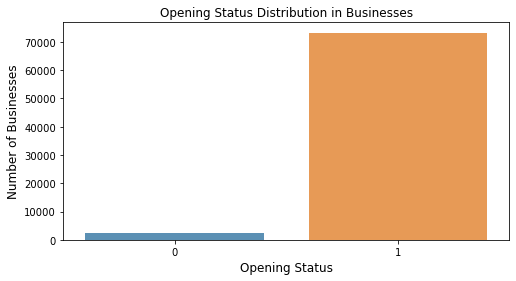

In [25]:
x = bus_df['is_open'].value_counts()
x = x.sort_index()
plt.figure(figsize = (8, 4))
ax = sns.barplot(x.index, x.values, alpha = 0.8)
plt.title("Opening Status Distribution in Businesses")
plt.ylabel("Number of Businesses", fontsize = 12)
plt.xlabel('Opening Status', fontsize = 12)
plt.savefig('is_open_distr_bus.png', bbox_inches = 'tight')

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


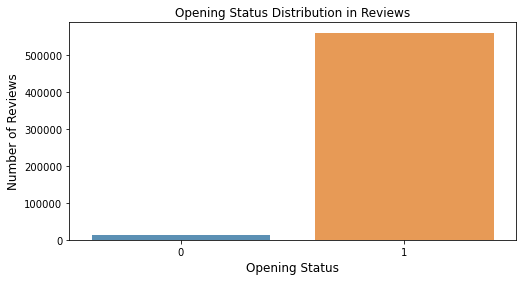

In [26]:
x = rev_df['is_open'].value_counts()
x = x.sort_values()
plt.figure(figsize = (8, 4))
ax = sns.barplot(x.index, x.values, alpha = 0.8)
plt.title("Opening Status Distribution in Reviews")
plt.ylabel("Number of Reviews", fontsize = 12)
plt.xlabel('Opening Status', fontsize = 12)
plt.savefig('is_open_distr_rev.png', bbox_inches = 'tight')

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


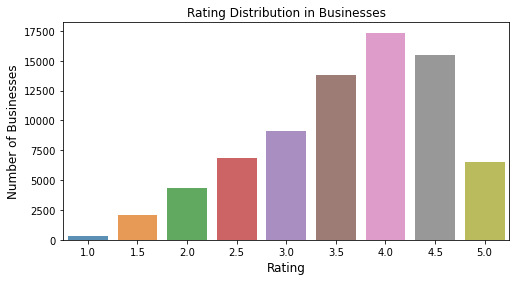

In [27]:
x = bus_df['stars'].value_counts()
x = x.sort_index()
plt.figure(figsize = (8, 4))
ax = sns.barplot(x.index, x.values, alpha = 0.8)
plt.title("Rating Distribution in Businesses")
plt.ylabel("Number of Businesses", fontsize = 12)
plt.xlabel('Rating', fontsize = 12)
plt.savefig('star_distr_bus.png', bbox_inches = 'tight')

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


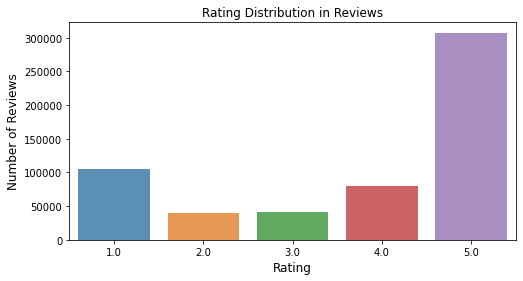

In [28]:
x = rev_df['stars'].value_counts()
x = x.sort_index()
plt.figure(figsize = (8, 4))
ax = sns.barplot(x.index, x.values, alpha = 0.8)
plt.title("Rating Distribution in Reviews")
plt.ylabel("Number of Reviews", fontsize = 12)
plt.xlabel('Rating', fontsize = 12)
plt.savefig('star_distr_rev.png', bbox_inches = 'tight')

In [29]:
x = bus_df.groupby(['stars', 'is_open'])['is_open'].size()
x_total = bus_df['stars'].value_counts().sort_index()
xx = list(chain.from_iterable(zip(x_total, x_total)))
percent = [a/b for a, b in zip(list(x), xx)]
percent

[0.008450704225352112,
 0.9915492957746479,
 0.017424975798644726,
 0.9825750242013552,
 0.015307288096870002,
 0.98469271190313,
 0.02316036352975667,
 0.9768396364702433,
 0.02851166886833994,
 0.9714883311316601,
 0.03992450638792102,
 0.960075493612079,
 0.0446685878962536,
 0.9553314121037464,
 0.03849129593810445,
 0.9615087040618956,
 0.020679012345679013,
 0.979320987654321]

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


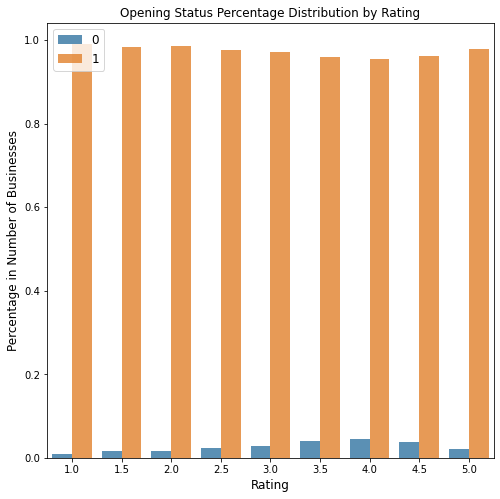

In [30]:
plt.figure(figsize = (8, 8))
ax = sns.barplot(x.index.get_level_values('stars'), percent, hue = x.index.get_level_values('is_open'), alpha = 0.8)
plt.title('Opening Status Percentage Distribution by Rating')
plt.ylabel('Percentage in Number of Businesses', fontsize=12)
plt.xlabel('Rating', fontsize=12)
plt.legend(fontsize=12)
plt.savefig('is_open_by_stars.png', bbox_inches = 'tight')

In [31]:
x = bus_df.groupby(['chain', 'is_open'])['is_open'].size()
x_total = bus_df['chain'].value_counts().sort_index()
xx = list(chain.from_iterable(zip(x_total, x_total)))
percent = [a/b for a, b in zip(list(x), xx)]
percent

[0.037779850746268655,
 0.9622201492537313,
 0.026063043835166638,
 0.9739369561648333]

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


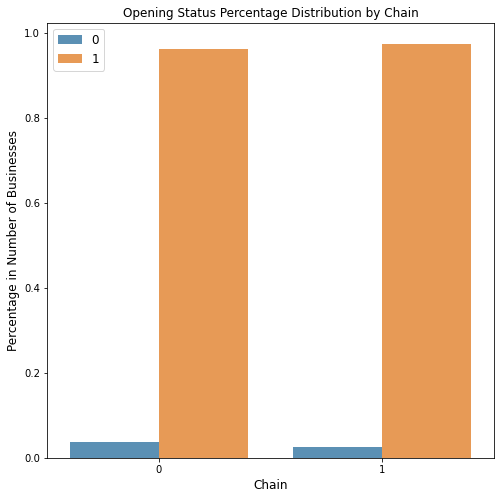

In [32]:
plt.figure(figsize = (8, 8))
ax = sns.barplot(x.index.get_level_values('chain'), percent, hue = x.index.get_level_values('is_open'), alpha = 0.8)
plt.title('Opening Status Percentage Distribution by Chain')
plt.ylabel('Percentage in Number of Businesses', fontsize=12)
plt.xlabel('Chain', fontsize=12)
plt.legend(fontsize=12)
plt.savefig('chain_distr_by_open.png', bbox_inches = 'tight')

In [33]:
bus_df.groupby(['is_open'])['number_of_checkins'].sum()

is_open
0     552564
1    9939884
Name: number_of_checkins, dtype: int64

In [34]:
bus_df.groupby(['is_open'])['business_id'].size()

is_open
0     2579
1    73241
Name: business_id, dtype: int64

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


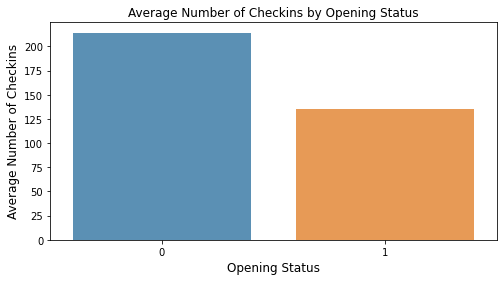

In [35]:
x = bus_df.groupby(['is_open'])['number_of_checkins'].mean()
x = x.sort_index()
plt.figure(figsize = (8, 4))
ax = sns.barplot(x.index, x.values, alpha = 0.8)
plt.title("Average Number of Checkins by Opening Status")
plt.ylabel("Average Number of Checkins", fontsize = 12)
plt.xlabel('Opening Status', fontsize = 12)
plt.savefig('num_checkins_open_status.png', bbox_inches = 'tight')

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


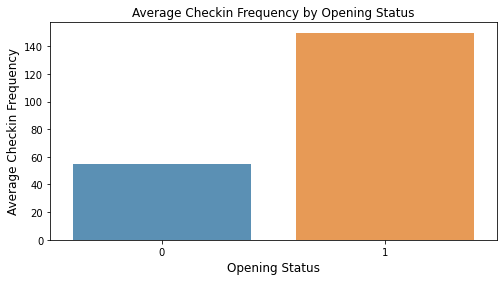

In [36]:
x = bus_df.groupby(['is_open'])['average_checkin_frequency'].mean()
x = x.sort_index()
plt.figure(figsize = (8, 4))
ax = sns.barplot(x.index, x.values, alpha = 0.8)
plt.title("Average Checkin Frequency by Opening Status")
plt.ylabel("Average Checkin Frequency", fontsize = 12)
plt.xlabel('Opening Status', fontsize = 12)
plt.savefig('checkin_freq_open_status.png', bbox_inches = 'tight')

In [37]:
x = bus_df.groupby(['stars', 'chain'])['chain'].size()
x_total = bus_df['stars'].value_counts().sort_index()
xx = list(chain.from_iterable(zip(x_total, x_total)))
percent = [a/b for a, b in zip(list(x), xx)]
percent

[0.37746478873239436,
 0.6225352112676056,
 0.2812197483059051,
 0.7187802516940949,
 0.31711217729038155,
 0.6828878227096185,
 0.4252418645558487,
 0.5747581354441513,
 0.520695728753853,
 0.47930427124614705,
 0.6488821138211383,
 0.3511178861788618,
 0.7685878962536024,
 0.2314121037463977,
 0.8633784655061251,
 0.13662153449387493,
 0.9347222222222222,
 0.06527777777777778]

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


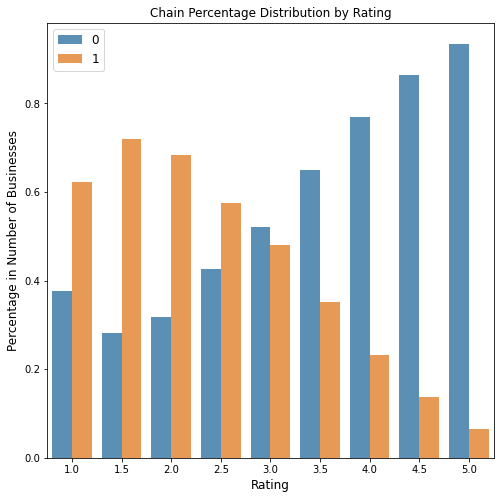

In [38]:
plt.figure(figsize = (8, 8))
ax = sns.barplot(x.index.get_level_values('stars'), percent, hue = x.index.get_level_values('chain'), alpha = 0.8)
plt.title('Chain Percentage Distribution by Rating')
plt.ylabel('Percentage in Number of Businesses', fontsize=12)
plt.xlabel('Rating', fontsize=12)
plt.legend(fontsize=12)
plt.savefig('stars_by_chain.png', bbox_inches = 'tight')

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


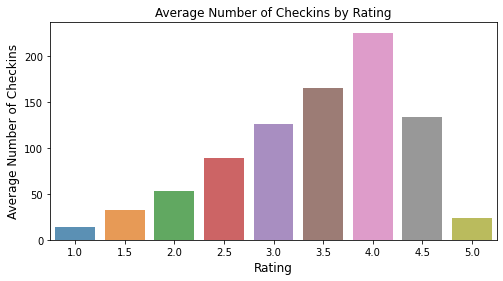

In [39]:
x = bus_df.groupby(['stars'])['number_of_checkins'].mean()
x = x.sort_index()
plt.figure(figsize = (8, 4))
ax = sns.barplot(x.index, x.values, alpha = 0.8)
plt.title("Average Number of Checkins by Rating")
plt.ylabel("Average Number of Checkins", fontsize = 12)
plt.xlabel('Rating', fontsize = 12)
plt.savefig('num_checkins_stars.png', bbox_inches = 'tight')

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


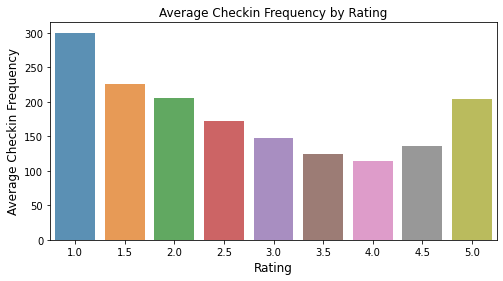

In [40]:
x = bus_df.groupby(['stars'])['average_checkin_frequency'].mean()
x = x.sort_index()
plt.figure(figsize = (8, 4))
ax = sns.barplot(x.index, x.values, alpha = 0.8)
plt.title("Average Checkin Frequency by Rating")
plt.ylabel("Average Checkin Frequency", fontsize = 12)
plt.xlabel('Rating', fontsize = 12)
plt.savefig('checkin_freq_stars.png', bbox_inches = 'tight')

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


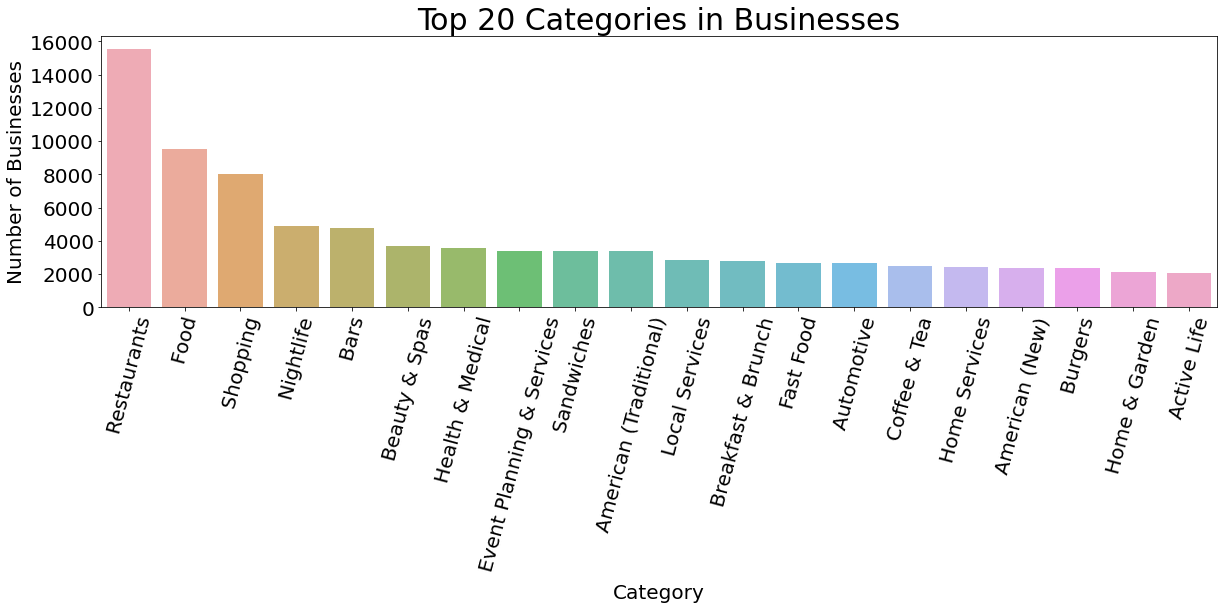

In [41]:
bus_cats = ''.join(bus_df['categories'].astype('str'))

cats = pd.DataFrame(bus_cats.split(','), columns=['categories'])

#prep for chart
x = cats.categories.value_counts()

x = x.sort_values(ascending = False)
x = x.iloc[0:20]

#chart
plt.figure(figsize=(20, 5))
ax = sns.barplot(x.index, x.values, alpha = 0.8)
plt.title("Top 20 Categories in Businesses",fontsize = 30)
locs, labels = plt.xticks()
plt.setp(labels, rotation = 75)
plt.ylabel('Number of Businesses', fontsize = 20)
plt.xlabel('Category', fontsize = 20)
plt.yticks(fontsize = 20)
plt.xticks(fontsize = 20)

#adding the text labels
# rects = ax.patches
# labels = x.values
# for rect, label in zip(rects, labels):
#     height = rect.get_height()
#     ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.savefig('top20_cats_bus.png', bbox_inches = 'tight')
plt.show()

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


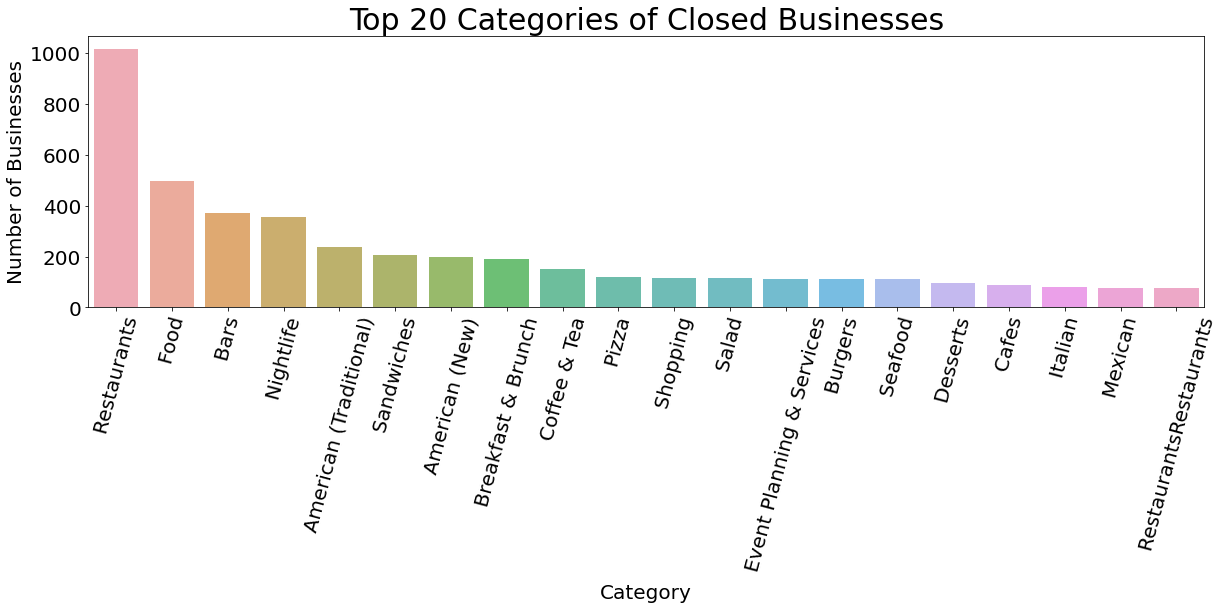

In [42]:
# American(traditional), American(new), Sandwiches, Breakfast&Brunch, Coffee&Tea, Pizza
bus_closed = bus_df.loc[bus_df['is_open'] == 0]
bus_closed_cats = ''.join(bus_closed['categories'].astype('str'))

closed_cats = pd.DataFrame(bus_closed_cats.split(','), columns=['categories'])

#prep for chart
x = closed_cats.categories.value_counts()

x = x.sort_values(ascending = False)
x = x.iloc[0:20]

#chart
plt.figure(figsize=(20, 5))
ax = sns.barplot(x.index, x.values, alpha = 0.8)
plt.title("Top 20 Categories of Closed Businesses",fontsize = 30)
locs, labels = plt.xticks()
plt.setp(labels, rotation = 75)
plt.ylabel('Number of Businesses', fontsize = 20)
plt.xlabel('Category', fontsize = 20)
plt.yticks(fontsize = 20)
plt.xticks(fontsize = 20)

#adding the text labels
# rects = ax.patches
# labels = x.values
# for rect, label in zip(rects, labels):
#     height = rect.get_height()
#     ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.savefig('top20_closed_cats.png', bbox_inches = 'tight')
plt.show()

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


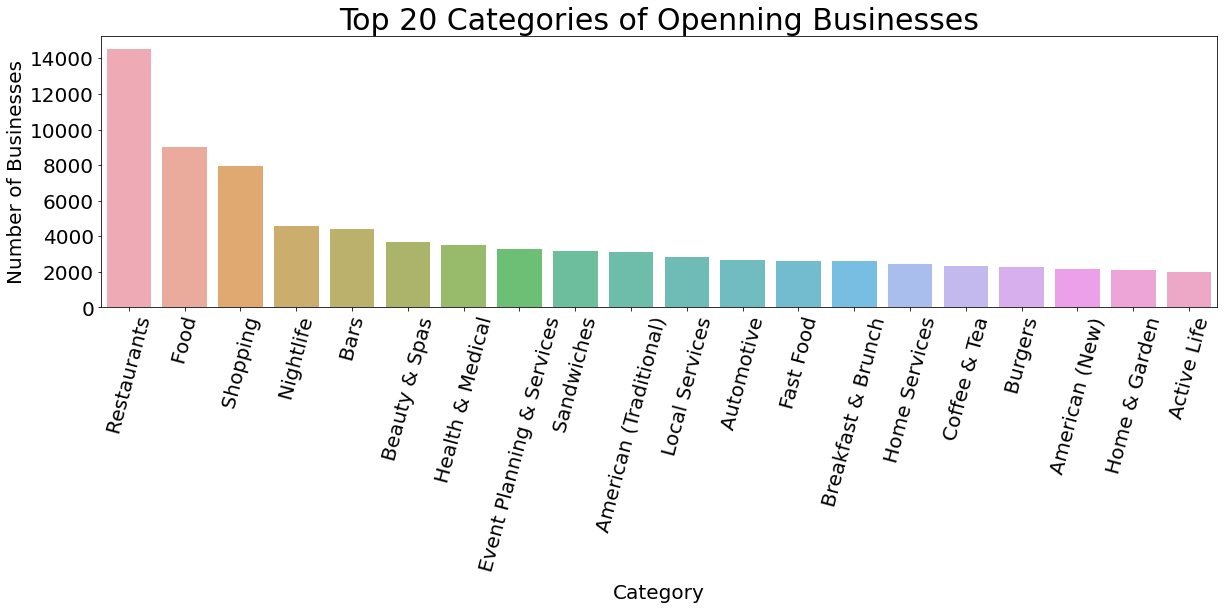

In [43]:
# Shpping, beauty&Spas
bus_open = bus_df.loc[bus_df['is_open'] == 1]
bus_open_cats = ''.join(bus_open['categories'].astype('str'))

open_cats = pd.DataFrame(bus_open_cats.split(','), columns=['categories'])

#prep for chart
x = open_cats.categories.value_counts()

x = x.sort_values(ascending = False)
x = x.iloc[0:20]

#chart
plt.figure(figsize=(20, 5))
ax = sns.barplot(x.index, x.values, alpha = 0.8)
plt.title("Top 20 Categories of Openning Businesses",fontsize = 30)
locs, labels = plt.xticks()
plt.setp(labels, rotation = 75)
plt.ylabel('Number of Businesses', fontsize = 20)
plt.xlabel('Category', fontsize = 20)
plt.yticks(fontsize = 20)
plt.xticks(fontsize = 20)

#adding the text labels
# rects = ax.patches
# labels = x.values
# for rect, label in zip(rects, labels):
#     height = rect.get_height()
#     ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.savefig('top20_open_cats.png', bbox_inches = 'tight')
plt.show()

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


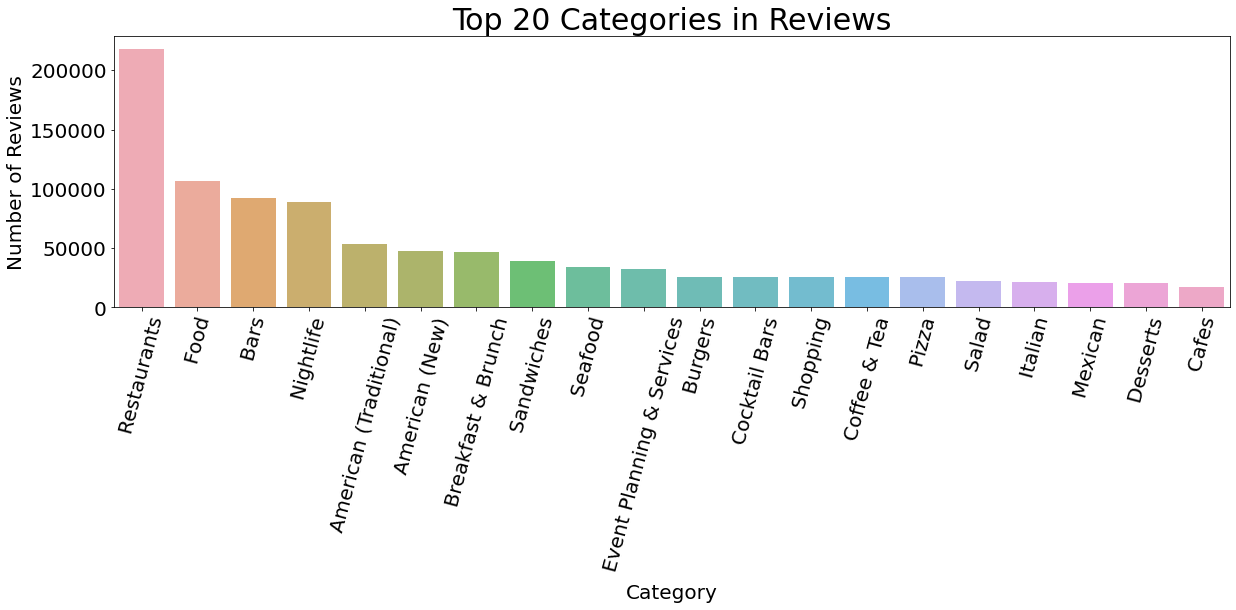

In [44]:
rev_cats = ''.join(rev_df['categories'].astype('str'))

cats = pd.DataFrame(rev_cats.split(','), columns=['categories'])

#prep for chart
x = cats.categories.value_counts()

x = x.sort_values(ascending = False)
x = x.iloc[0:20]

#chart
plt.figure(figsize=(20, 5))
ax = sns.barplot(x.index, x.values, alpha = 0.8)
plt.title("Top 20 Categories in Reviews",fontsize = 30)
locs, labels = plt.xticks()
plt.setp(labels, rotation = 75)
plt.ylabel('Number of Reviews', fontsize = 20)
plt.xlabel('Category', fontsize = 20)
plt.yticks(fontsize = 20)
plt.xticks(fontsize = 20)

#adding the text labels
# rects = ax.patches
# labels = x.values
# for rect, label in zip(rects, labels):
#     height = rect.get_height()
#     ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.savefig('top20_cats_rev.png', bbox_inches = 'tight')
plt.show()

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


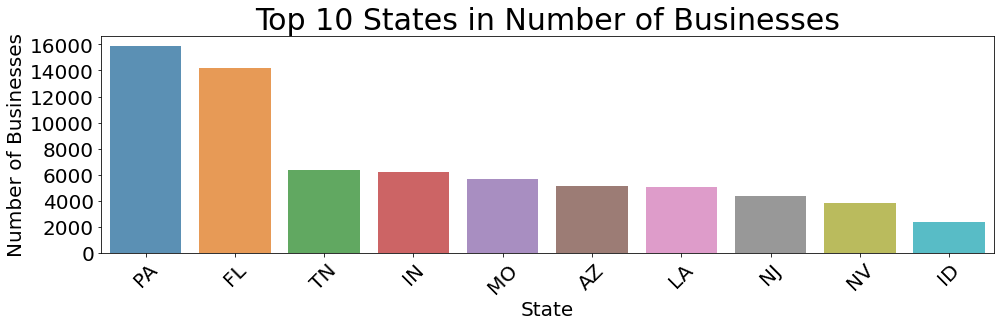

In [45]:
x = bus_df['state'].value_counts()
x = x.sort_values(ascending=False)
x = x.iloc[0:10]
plt.figure(figsize=(16,4))
ax = sns.barplot(x.index, x.values, alpha=0.8)
plt.title("Top 10 States in Number of Businesses", fontsize = 30)
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
plt.ylabel('Number of Businesses', fontsize=20)
plt.xlabel('State', fontsize=20)
plt.yticks(fontsize = 20)
plt.xticks(fontsize = 20)
plt.savefig('top10_sta_bus.png', bbox_inches = 'tight')

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


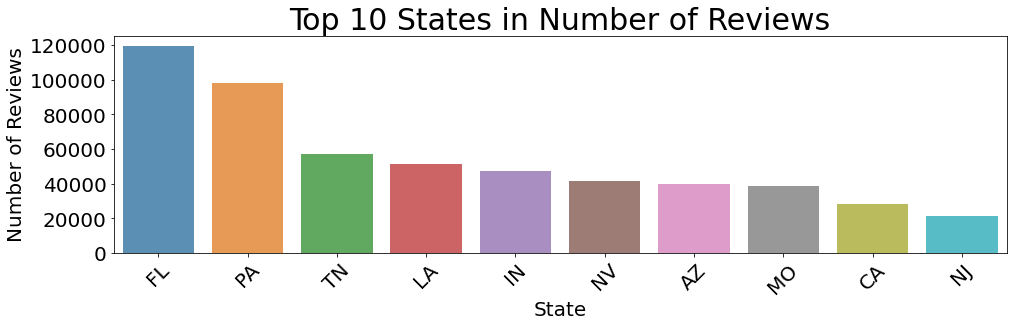

In [46]:
x = rev_df['state'].value_counts()
x = x.sort_values(ascending=False)
x = x.iloc[0:10]
plt.figure(figsize=(16,4))
ax = sns.barplot(x.index, x.values, alpha=0.8)
plt.title("Top 10 States in Number of Reviews", fontsize = 30)
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
plt.ylabel('Number of Reviews', fontsize=20)
plt.xlabel('State', fontsize=20)
plt.yticks(fontsize = 20)
plt.xticks(fontsize = 20)
plt.savefig('top10_sta_rev.png', bbox_inches = 'tight')

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


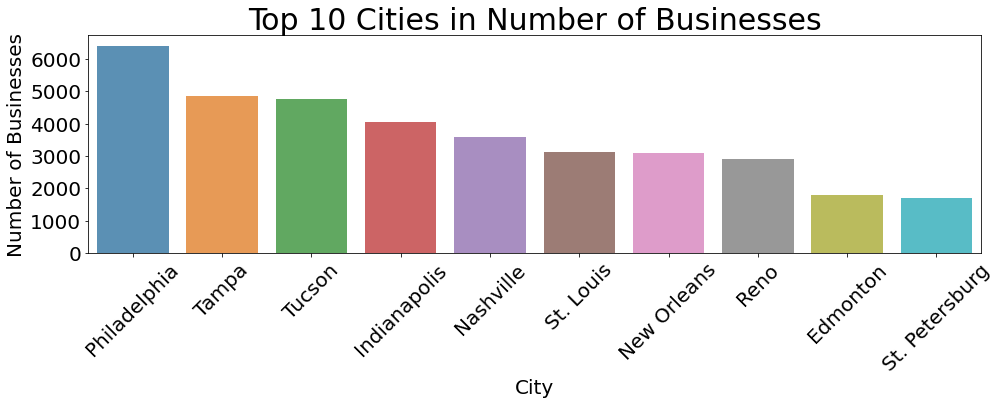

In [47]:
x = bus_df['city'].value_counts()
x = x.sort_values(ascending=False)
x = x.iloc[0:10]
plt.figure(figsize=(16,4))
ax = sns.barplot(x.index, x.values, alpha=0.8)
plt.title("Top 10 Cities in Number of Businesses", fontsize = 30)
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
plt.ylabel('Number of Businesses', fontsize=20)
plt.xlabel('City', fontsize=20)
plt.yticks(fontsize = 20)
plt.xticks(fontsize = 20)
plt.savefig('top10_city_bus.png', bbox_inches = 'tight')

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


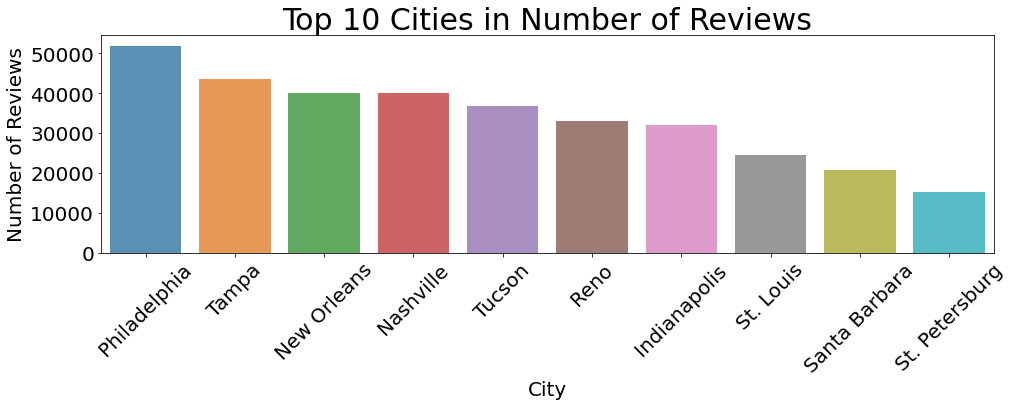

In [48]:
x = rev_df['city'].value_counts()
x = x.sort_values(ascending=False)
x = x.iloc[0:10]
plt.figure(figsize=(16,4))
ax = sns.barplot(x.index, x.values, alpha=0.8)
plt.title("Top 10 Cities in Number of Reviews", fontsize = 30)
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
plt.ylabel('Number of Reviews', fontsize=20)
plt.xlabel('City', fontsize=20)
plt.yticks(fontsize = 20)
plt.xticks(fontsize = 20)
plt.savefig('top10_city_rev.png', bbox_inches = 'tight')

In [49]:
bus_df.loc[bus_df['city'] == 'New Orleans']

,business_id,name,city,state,latitude,longitude,stars,review_count,is_open,categories,earliest_checkin_date,latest_checkin_date,number_of_checkins,average_checkin_frequency,influence,chain
10,M0XSSHqrASOnhgbWDJIpQA,Herb Import Co,New Orleans,LA,29.941468,-90.129953,4.0,5,1,"Vape Shops, Tobacco Shops, Personal Shopping, ...",2013-01-10,2019-01-25,78,28,0,0
29,uczmbBk5O3tYhGue13dCDg,New Orleans Spirit Tours,New Orleans,LA,29.958431,-90.065173,4.0,38,1,"Hotels & Travel, Tours, Local Flavor",2011-02-20,2017-06-15,44,53,0,0
40,YNjyv0gfOr2g8lbmUpTnKg,Copper Vine,New Orleans,LA,29.950647,-90.074427,4.5,350,1,"Nightlife, Pubs, Event Planning & Services, Wi...",2018-08-31,2022-01-04,282,4,286,0
46,TLZ3-eDPLhUzfsWO4ad6Ug,Mahony's Po-Boys & Seafood,New Orleans,LA,29.955415,-90.070062,4.0,382,1,"Restaurants, Seafood, Cajun/Creole",2018-06-22,2022-01-08,404,3,76,0
125,Edg22x3CZkIv0GUib2oEFA,Mellow Mushroom,New Orleans,LA,29.948624,-90.131250,3.5,149,0,"Pizza, Restaurants, Bars, Nightlife, Sandwiches",2013-04-01,2020-02-08,564,4,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75541,01q_jIJWEyw0ATi3Q5CpBw,Sephora,New Orleans,LA,29.954553,-90.064293,4.0,27,1,"Shopping, Beauty & Spas, Cosmetics & Beauty Su...",2017-06-09,2021-12-30,35,48,15,1
75609,ajM1U0EUVF8zKi-d-JKcDg,Carnaval Lounge,New Orleans,LA,29.969005,-90.055903,4.5,9,1,"Nightlife, Brazilian, Restaurants, Bars, Cockt...",2019-09-21,2021-10-08,12,68,6,0
75689,2OcVR4GRcmVsC118dn2QWA,Jackson Brewery,New Orleans,LA,29.955925,-90.062962,2.5,41,1,"Bars, Restaurants, Nightlife, Shopping Centers...",2010-03-31,2021-12-20,243,17,0,0
75720,PBbhDFJdUS7ebuRa1ggjaQ,Cafe Gentilly,New Orleans,LA,30.013081,-90.050785,4.5,100,0,"Seafood, Restaurants, Burgers, Cajun/Creole, B...",2013-10-21,2020-06-18,111,22,-1,0


## Map

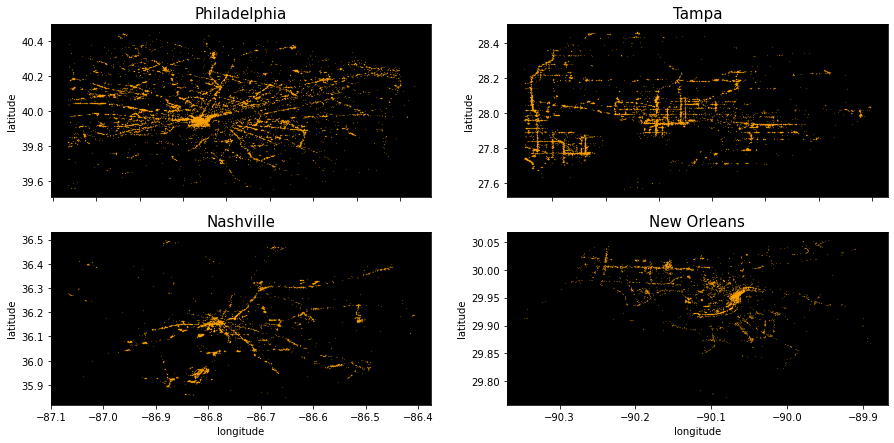

In [50]:
map_data = bus_df[['latitude', 'longitude', 'review_count']]
fig, axs = plt.subplots(2, 2, figsize=(15,7))

# Philadelphia
lat = 39.952583
lon = -75.165222

lon_min, lon_max = lon-0.3,lon+0.5
lat_min, lat_max = lat-0.4,lat+0.5

ratings_data_phil = map_data[(map_data["longitude"]>lon_min) &\
                    (map_data["longitude"]<lon_max) &\
                    (map_data["latitude"]>lat_min) &\
                    (map_data["latitude"]<lat_max)]

ratings_data_phil.plot(kind='scatter', x='longitude', y='latitude', sharex = True, color='orange', s=.02, alpha=.8, subplots = True, ax = axs[0, 0])
axs[0, 0].set_title("Philadelphia", fontsize = 15)
axs[0, 0].set_facecolor('black')

# Tampa
lat = 27.964157
lon = -82.452606

lon_min, lon_max = lon-0.3,lon+0.5
lat_min, lat_max = lat-0.4,lat+0.5

ratings_data_tempa = map_data[(map_data["longitude"]>lon_min) &\
                    (map_data["longitude"]<lon_max) &\
                    (map_data["latitude"]>lat_min) &\
                    (map_data["latitude"]<lat_max)]

ratings_data_tempa.plot(kind='scatter', x='longitude', y='latitude', sharex = True, color='orange', s=.02, alpha=.8, subplots = True, ax = axs[0, 1])
axs[0, 1].set_title("Tampa", fontsize = 15)
axs[0, 1].set_facecolor('black')

# Nashville
lat = 36.174465
lon = -86.767960

lon_min, lon_max = lon-0.3,lon+0.5
lat_min, lat_max = lat-0.4,lat+0.5

ratings_data_nash = map_data[(map_data["longitude"]>lon_min) &\
                    (map_data["longitude"]<lon_max) &\
                    (map_data["latitude"]>lat_min) &\
                    (map_data["latitude"]<lat_max)]

ratings_data_nash.plot(kind='scatter', x='longitude', y='latitude', sharex = True, color='orange', s=.02, alpha=.8 , subplots = True, ax = axs[1, 0])
axs[1, 0].set_title("Nashville", fontsize = 15)
axs[1, 0].set_facecolor('black')

# New Orleans
lat = 29.9511
lon = -90.0715

lon_min, lon_max = lon-0.3,lon+0.5
lat_min, lat_max = lat-0.4,lat+0.5

ratings_data_newor = map_data[(map_data["longitude"]>lon_min) &\
                    (map_data["longitude"]<lon_max) &\
                    (map_data["latitude"]>lat_min) &\
                    (map_data["latitude"]<lat_max)]

ratings_data_newor.plot(kind='scatter', x='longitude', y='latitude', sharex = True, color='orange', s=.02, alpha=.8, subplots = True, ax = axs[1, 1])
axs[1, 1].set_title("New Orleans", fontsize = 15)
axs[1, 1].set_facecolor('black')
plt.savefig('city_map.png', bbox_inches = 'tight')

# Text Mining

## Text Cleaning

In [52]:
def text_prepare(x):
    x = BeautifulSoup(x).get_text()
    x = re.sub('[^a-z\s]', '', x.lower())
    x = re.sub(r"http\S+", "", x)
    x = re.sub("@[^\s]*", "", x)
    x = re.sub("#[^\s]*", "", x)
    x = re.sub('[0-9]*[+-:]*[0-9]+', '', x)
    x = re.sub("'s", "", x) 
    x = re.sub(r"won't", "will not", x)
    x = re.sub(r"wouldn't", "would not", x)
    x = re.sub(r"couldn't", "could not", x)
    x = re.sub(r"\'d", " would", x)
    x = re.sub(r"can\'t", "can not", x)
    x = re.sub(r"n\'t", " not", x)
    x = re.sub(r"\'re", " are", x)
    x = re.sub(r"\'s", " is", x)
    x = re.sub(r"\'ll", " will", x)
    x = re.sub(r"\'t", " not", x)
    x = re.sub(r"\'ve", " have", x)
    x = re.sub(r"\'m", " am", x)
    x = [w for w in x.split() if w not in set(stopwords)]
    return ' '.join(x)

i = nltk.corpus.stopwords.words('english')

j = list(string.punctuation)

stopwords = set(i).union(j)

rev_df['text_clear'] = rev_df['text'].apply(text_prepare)
lemmatizer = WordNetLemmatizer()
rev_df['text_clear'] = rev_df['text_clear'].apply(lambda x: " ".join([lemmatizer.lemmatize(w) for w in nltk.word_tokenize(x)]))

/opt/anaconda3/lib/python3.8/site-packages/bs4/__init__.py:417: MarkupResemblesLocatorWarning: "https://www.nydailynews.com/news/national/ny-florida-restaurant-owner-beat-up-man-negative-yelp-reviews-20201014-sguo3zpeovaj7f5raszcilf7gm-story.html" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/bs4/__init__.py:332: MarkupResemblesLocatorWarning: "." looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


In [53]:
rev_df['text_clear'].head()

0    took u minute seated even though wait supposed...
1    horrible experience looked yelp see wait time ...
2    multiple time breakfast everyone left happy fo...
3    im surprised negative review food service mh m...
4    place okay maybe try different location place ...
Name: text_clear, dtype: object

## Wordcloud

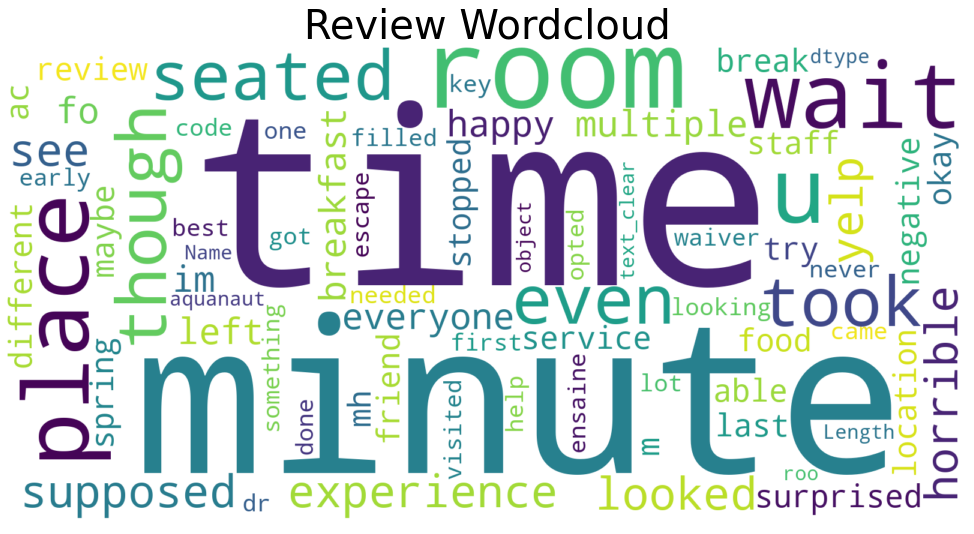

In [54]:
wc = WordCloud(width=1600, height=800, random_state=1, max_words=200000000, background_color = "white")
wc.generate(str(rev_df['text_clear'])) 
plt.figure(figsize=(20,10))
plt.title("Review Wordcloud", fontsize=40)
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=10)
plt.savefig('rev_wc.png', bbox_inches = 'tight')
plt.show()

In [55]:
rev_sent = rev_df[['text_clear', 'sentiment']]
rev_sent.head()

,text_clear,sentiment
0,took u minute seated even though wait supposed...,1
1,horrible experience looked yelp see wait time ...,-1
2,multiple time breakfast everyone left happy fo...,1
3,im surprised negative review food service mh m...,1
4,place okay maybe try different location place ...,-1


In [56]:
pos = rev_sent[rev_sent['sentiment']==1]['text_clear']
neg = rev_sent[rev_sent['sentiment']==-1]['text_clear']

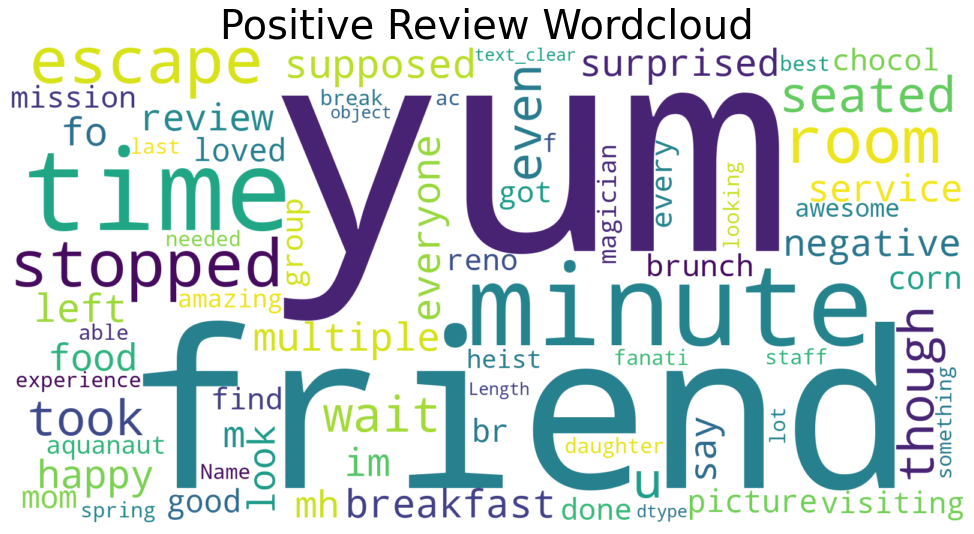

In [57]:
wc = WordCloud(width=1600, height=800, random_state=1, max_words=100, background_color = 'white')
wc.generate(str(pos)) 
plt.figure(figsize=(20,10))
plt.title("Positive Review Wordcloud", fontsize=40)
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=10)
plt.savefig('rev_wc_pos.png', bbox_inches = 'tight')
plt.show()

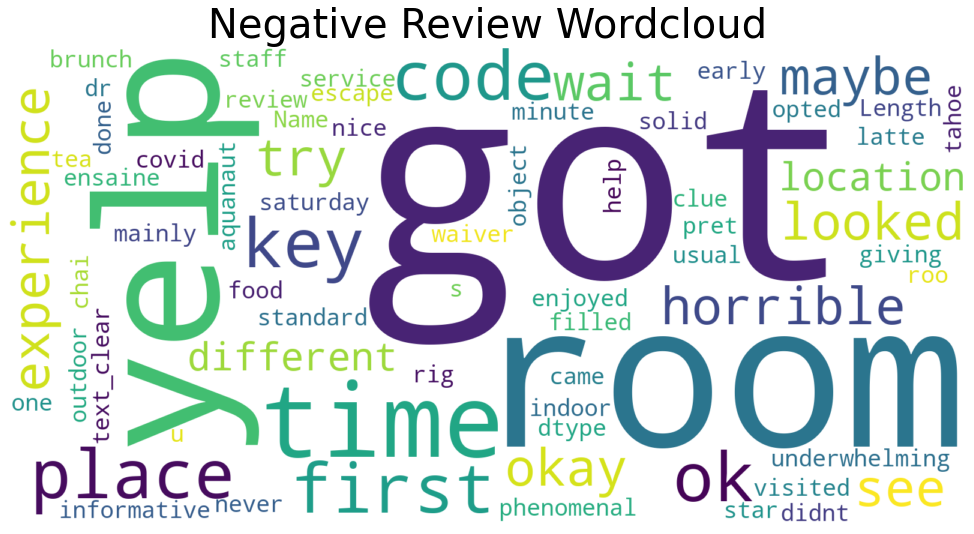

In [58]:
wc = WordCloud(width=1600, height=800, random_state=1, max_words=100, background_color = 'white')
wc.generate(str(neg)) 
plt.figure(figsize=(20,10))
plt.title("Negative Review Wordcloud", fontsize=40)
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=10)
plt.savefig('rev_wc_neg.png', bbox_inches = 'tight')
plt.show()

## Bigrams

In [59]:
from nltk import word_tokenize
from nltk.util import ngrams
texts = list(rev_df['text_clear'].values)
for line in texts:
    token = word_tokenize(line)
    bigram = list(ngrams(token, 2))

In [60]:
bigram

[('never', 'done'),
 ('done', 'escape'),
 ('escape', 'room'),
 ('room', 'opted'),
 ('opted', 'aquanaut'),
 ('aquanaut', 'room'),
 ('room', 'room'),
 ('room', 'looked'),
 ('looked', 'neat'),
 ('neat', 'really'),
 ('really', 'didnt'),
 ('didnt', 'know'),
 ('know', 'mostly'),
 ('mostly', 'fumbled'),
 ('fumbled', 'around'),
 ('around', 'solving'),
 ('solving', 'puzzle'),
 ('puzzle', 'order'),
 ('order', 'halfway'),
 ('halfway', 'host'),
 ('host', 'let'),
 ('let', 'u'),
 ('u', 'know'),
 ('know', 'missed'),
 ('missed', 'video'),
 ('video', 'beginning'),
 ('beginning', 'would'),
 ('would', 'really'),
 ('really', 'helpful'),
 ('helpful', 'found'),
 ('found', 'much'),
 ('much', 'sooner'),
 ('sooner', 'pretty'),
 ('pretty', 'much'),
 ('much', 'disaster'),
 ('disaster', 'start'),
 ('start', 'finish'),
 ('finish', 'wasnt'),
 ('wasnt', 'enjoyable'),
 ('enjoyable', 'experience'),
 ('experience', 'would'),
 ('would', 'try'),
 ('try', 'another'),
 ('another', 'escape'),
 ('escape', 'room'),
 ('room', 

# Model Fitting and Evaluation

## Logistic Regression

### Model 1

In [82]:
bus_df['chain'] = bus_df['chain'].astype(np.object)

<ipython-input-82-cb549a871082>:1: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  bus_df['chain'] = bus_df['chain'].astype(np.object)


In [83]:
bus_df['is_closed'] = np.where(bus_df['is_open'] == 1, 0, 1)

In [84]:
cols = ['longitude', 'latitude', 'stars', 'review_count', 'number_of_checkins', 'average_checkin_frequency', 'influence', 'chain']
X = bus_df[cols]
y = bus_df['is_closed']

In [85]:
X.isna().sum()

longitude                    0
latitude                     0
stars                        0
review_count                 0
number_of_checkins           0
average_checkin_frequency    0
influence                    0
chain                        0
dtype: int64

In [86]:
y.isnull().sum()

0

In [87]:
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size = 0.2, random_state = 2022)

In [88]:
train_X = pd.DataFrame(train_X)
train_y = pd.DataFrame(train_y)
test_X = pd.DataFrame(test_X)
test_y = pd.DataFrame(test_y)

In [89]:
lr_model = LogisticRegression(solver = 'newton-cg')
lr_model.fit(train_X, train_y)
pred_y = lr_model.predict(test_X)
f1score = f1_score(test_y, pred_y)
print("F1 score is: ", f1score)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


F1 score is:  0.0


In [90]:
pred_y = lr_model.predict_proba(test_X)
pred_y = pred_y[:, 1]
thresholds = np.arange(0, 1, 0.001)
def to_labels(pos_probs, threshold):
    return(pos_probs >= threshold).astype('int')
scores = [f1_score(test_y, to_labels(pred_y, t)) for t in thresholds]
index = np.argmax(scores)
opt_thres = thresholds[index]
print("Optimal threshold is: ", opt_thres, "\nF1 score is: ", scores[index])

Optimal threshold is:  0.051000000000000004 
F1 score is:  0.11979005866008027


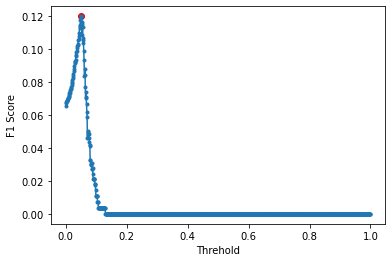

In [91]:
plt.plot(thresholds, scores, marker = '.')
plt.scatter(thresholds[index], scores[index], marker = 'o', color = 'red')
plt.xlabel("Threhold")
plt.ylabel("F1 Score")
plt.savefig("lr_f1.png", bbox_inches = "tight")
plt.show()

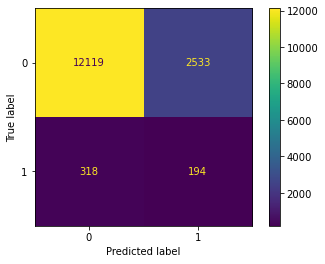

In [92]:
pred_y = np.where(pred_y >= opt_thres, 1, 0)
lr_cm = confusion_matrix(test_y, pred_y, labels = lr_model.classes_)
lr_disp = ConfusionMatrixDisplay(confusion_matrix = lr_cm, display_labels = lr_model.classes_)
lr_disp.plot()
plt.savefig("lr_cm.png", bbox_inches = "tight")
plt.show()

In [93]:
lr_scores = pd.DataFrame()
lr_scores['Accuracy Score'] = [accuracy_score(test_y, pred_y)]
lr_scores['ROC AUC Score'] = [roc_auc_score(test_y, pred_y)]
lr_scores

,Accuracy Score,ROC AUC Score
0,0.811989,0.603014


## SVM

In [75]:
X = rev_df['text_clear']
y = rev_df['is_open']
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size = 0.2, random_state = 2022)

In [76]:
vectorizer= TfidfVectorizer()
tf_X_train = vectorizer.fit_transform(train_X)
tf_X_test = vectorizer.transform(test_X)

In [77]:
clf = LinearSVC(random_state = 2022)
clf.fit(tf_X_train, train_y)
pred_y = clf.predict(tf_X_test)

In [78]:
svm_cm = confusion_matrix(test_y, pred_y, labels = clf.classes_)

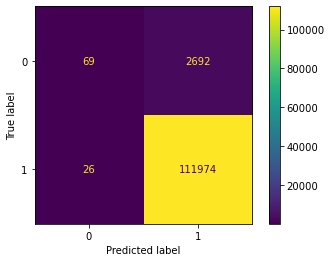

In [79]:
svm_disp = ConfusionMatrixDisplay(confusion_matrix = svm_cm, display_labels = clf.classes_)
svm_disp.plot()
plt.savefig("svm_cm.png", bbox_inches = "tight")
plt.show()

In [80]:
accuracy_score(test_y, pred_y)

0.9763159958522495

## Bidirectional LSTM

### Bi-LSTM 1

In [115]:
texts = rev_df['text_clear'].values
labels = rev_df['is_open'].values

In [116]:
MAX_NUM_WORDS=1000 # how many unique words to use (i.e num rows in embedding vector)
MAX_SEQUENCE_LENGTH=100 # max number of words in a review to use


tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

labels = to_categorical(np.asarray(labels))
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

Found 325131 unique tokens.
Shape of data tensor: (1025744, 100)
Shape of label tensor: (1025744, 2)


In [117]:
VALIDATION_SPLIT=0.2

indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

x_train = data[:-nb_validation_samples]
y_train = labels[:-nb_validation_samples]
x_val = data[-nb_validation_samples:]
y_val = labels[-nb_validation_samples:]

In [118]:
GLOVE_DIR='/Users/zhengyuxiu/Desktop/MAS_thesis/glove/'

embeddings_index = {}
f = open(os.path.join(GLOVE_DIR, 'glove.6B.50d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [119]:
EMBEDDING_DIM = 50 # how big is each word vector

embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [120]:
from keras.layers import Embedding

embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

In [121]:
inp = Input(shape=(MAX_SEQUENCE_LENGTH,))
x = embedded_sequences = embedding_layer(inp)
x = Bidirectional(LSTM(50, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))(x)
x = GlobalMaxPool1D()(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(2, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [122]:
model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=2, batch_size=128)

Epoch 1/2
6411/6411 [==============================] - 706s 109ms/step - loss: 0.1146 - accuracy: 0.9756 - val_loss: 0.1114 - val_accuracy: 0.9760
Epoch 2/2
6411/6411 [==============================] - 701s 109ms/step - loss: 0.1122 - accuracy: 0.9758 - val_loss: 0.1103 - val_accuracy: 0.9760


### Bi-LSTM 2

In [124]:
GLOVE_DIR='/Users/zhengyuxiu/Desktop/MAS_thesis/glove/'

embeddings_index = {}
f = open(os.path.join(GLOVE_DIR, 'glove.6B.300d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [125]:
EMBEDDING_DIM = 300 # how big is each word vector

embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [126]:
from keras.layers import Embedding

embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

In [127]:
inp = Input(shape=(MAX_SEQUENCE_LENGTH,))
x = embedded_sequences = embedding_layer(inp)
x = Bidirectional(LSTM(300, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))(x)
x = GlobalMaxPool1D()(x)
x = Dense(300, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(2, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [128]:
model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=2, batch_size=128)

Epoch 1/2
6411/6411 [==============================] - 9130s 1s/step - loss: 0.1129 - accuracy: 0.9758 - val_loss: 0.1153 - val_accuracy: 0.9760
Epoch 2/2
6411/6411 [==============================] - 10317s 2s/step - loss: 0.1111 - accuracy: 0.9758 - val_loss: 0.1101 - val_accuracy: 0.9760
